In [1]:
from datasets import load_dataset

from transformers import Qwen2AudioForConditionalGeneration, AutoProcessor
import librosa
from datasets import load_dataset

# Load the Hugging Face dataset
# Assuming the dataset has an 'audio' column with audio files and a 'label' column with emotion labels

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
model = Qwen2AudioForConditionalGeneration.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct", device_map="auto")


# Replace 'your_dataset_name' with the name of your Hugging Face dataset
dataset = load_dataset("cairocode/IEMOCAP_WAV")

# Check the dataset structure



c:\Users\Paolo\Documents\carol_emo_rec\MLLM\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [2]:
from datasets import load_dataset, concatenate_datasets

def filter_m_examples(example):
    return example["label"] != 4 and example["label"] != 5 and example["speakerID"]==937
dataset  = dataset.filter(filter_m_examples)
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

combined_dataset = concatenate_datasets([train_dataset, validation_dataset, test_dataset])

In [3]:
from datasets import ClassLabel

# Check the unique labels in your dataset
unique_labels = combined_dataset.unique("label")
print("Unique labels:", unique_labels)

# Create a ClassLabel feature
label_feature = ClassLabel(names=sorted(unique_labels))  # Sort to ensure consistent order

# Cast the label column to ClassLabel type
combined_dataset = combined_dataset.cast_column("label", label_feature)

# Perform the stratified split
split_ratio = 0.8  # 80% train, 20% test
balanced_splits = combined_dataset.train_test_split(
    test_size=1 - split_ratio,
    stratify_by_column="label"  # Now it's of ClassLabel type
)

# Access train and test sets
train_dataset = balanced_splits["train"]
test_dataset = balanced_splits["test"]

# Verify the distribution of classes in both sets
train_class_distribution = train_dataset.to_pandas()["label"].value_counts()
test_class_distribution = test_dataset.to_pandas()["label"].value_counts()

print("Train class distribution:")
print(train_class_distribution)
print("\nTest class distribution:")
print(test_class_distribution)

Unique labels: [0, 1, 2, 3]
Train class distribution:
label
0    181
3     77
1     61
2     54
Name: count, dtype: int64

Test class distribution:
label
0    45
3    20
1    16
2    13
Name: count, dtype: int64


In [4]:
ds  = train_dataset

In [5]:
import torch
check_dir = r"H:\My Drive\MASC\QWEN2\checkpoints\checkpoint_epoch_0_batch_40.pt"
checkpoint = torch.load(check_dir, map_location="cpu")
print(checkpoint['model_state_dict'].keys())
relevant_state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if "layer31" in k}
model.load_state_dict(relevant_state_dict, strict=False)

C:\Users\Paolo\AppData\Local\Temp\ipykernel_39456\3456585315.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(check_dir, map_location="cpu")


odict_keys(['audio_tower.conv1.weight', 'audio_tower.conv1.bias', 'audio_tower.conv2.weight', 'audio_tower.conv2.bias', 'audio_tower.embed_positions.weight', 'audio_tower.layers.0.self_attn.k_proj.weight', 'audio_tower.layers.0.self_attn.v_proj.weight', 'audio_tower.layers.0.self_attn.v_proj.bias', 'audio_tower.layers.0.self_attn.q_proj.weight', 'audio_tower.layers.0.self_attn.q_proj.bias', 'audio_tower.layers.0.self_attn.out_proj.weight', 'audio_tower.layers.0.self_attn.out_proj.bias', 'audio_tower.layers.0.self_attn_layer_norm.weight', 'audio_tower.layers.0.self_attn_layer_norm.bias', 'audio_tower.layers.0.fc1.weight', 'audio_tower.layers.0.fc1.bias', 'audio_tower.layers.0.fc2.weight', 'audio_tower.layers.0.fc2.bias', 'audio_tower.layers.0.final_layer_norm.weight', 'audio_tower.layers.0.final_layer_norm.bias', 'audio_tower.layers.1.self_attn.k_proj.weight', 'audio_tower.layers.1.self_attn.v_proj.weight', 'audio_tower.layers.1.self_attn.v_proj.bias', 'audio_tower.layers.1.self_attn.q_

_IncompatibleKeys(missing_keys=['audio_tower.conv1.weight', 'audio_tower.conv1.bias', 'audio_tower.conv2.weight', 'audio_tower.conv2.bias', 'audio_tower.embed_positions.weight', 'audio_tower.layers.0.self_attn.k_proj.weight', 'audio_tower.layers.0.self_attn.v_proj.weight', 'audio_tower.layers.0.self_attn.v_proj.bias', 'audio_tower.layers.0.self_attn.q_proj.weight', 'audio_tower.layers.0.self_attn.q_proj.bias', 'audio_tower.layers.0.self_attn.out_proj.weight', 'audio_tower.layers.0.self_attn.out_proj.bias', 'audio_tower.layers.0.self_attn_layer_norm.weight', 'audio_tower.layers.0.self_attn_layer_norm.bias', 'audio_tower.layers.0.fc1.weight', 'audio_tower.layers.0.fc1.bias', 'audio_tower.layers.0.fc2.weight', 'audio_tower.layers.0.fc2.bias', 'audio_tower.layers.0.final_layer_norm.weight', 'audio_tower.layers.0.final_layer_norm.bias', 'audio_tower.layers.1.self_attn.k_proj.weight', 'audio_tower.layers.1.self_attn.v_proj.weight', 'audio_tower.layers.1.self_attn.v_proj.bias', 'audio_tower.l

In [6]:
import numpy as np
import soundfile as sf
from io import BytesIO
from transformers import AutoProcessor, Qwen2AudioForConditionalGeneration
import librosa
import warnings
import csv
warnings.filterwarnings("ignore", message="It is strongly recommended to pass the `sampling_rate` argument")
# Map emotions to numbers
emotion_mapping = {
    "Neutral": 0,
    "Happy": 1,
    "Sad": 2,
    "Angry": 3
}


# # Load processor and model
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
# model = Qwen2AudioForConditionalGeneration.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct", device_map="auto")
csv_file = "emotion_results_937_trainsplit_e40.csv"
fieldnames = ["Transcript", "Label", "Predicted Emotion", "Mapped Value", "speaker_id"]
with open(csv_file, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()


# Example dataset
for i in range(len(ds)):
    transcript = ds['transcript'][i]
    actual_label = ds['label'][i]
    speaker_id = ds['speakerID'][i]
    conversations = [
        [{"role": "user", "content": [
            {"type": "audio", "array": ds['audio'][i]['array']},
            {"type": "text", "text": "Is this person happy, sad, angry or neutral?, answer in one word"}
        ]}],
    ]

    # Apply the chat template
    text = [processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False) for conversation in conversations]

    # Prepare audio inputs
    audios = []
    for conversation in conversations:
        for message in conversation:
            if isinstance(message["content"], list):
                for ele in message["content"]:
                    if ele["type"] == "audio":
                        # Convert numpy array to WAV and load with librosa
                        audio_data = ele["array"]
                        with BytesIO() as buffer:
                            sf.write(buffer, audio_data, samplerate=16000, format="WAV")  # Assuming 16kHz input
                            buffer.seek(0)
                            y, _ = librosa.load(buffer, sr=processor.feature_extractor.sampling_rate)
                            audios.append(y.astype(np.float32))

    # Prepare inputs
    inputs = processor(
        text=text,
        audios=audios,
        sampling_rate=16000,  # Explicitly set the sampling rate here
        return_tensors="pt",
        padding=True
    )

    # Fix attention_mask to avoid starting with 0 unless explicitly invalid
    inputs["attention_mask"][:, 0] = 1

    # Debugging: Inspect masks and tensor shapes
    special_audio_token_mask = (inputs["input_ids"] == model.config.audio_token_index)
    # print("special_audio_token_mask Shape:", special_audio_token_mask.shape)
    # print("special_audio_token_mask Sum:", special_audio_token_mask.sum().item())

    # Ensure special_audio_token_mask is valid
    if special_audio_token_mask.sum() == 0:
        # print("Warning: No special audio tokens found in input_ids.")
        # Add a placeholder token if required by the model
        audio_token_id = getattr(model.config, "audio_token_index", None)
        if audio_token_id is not None:
            inputs["input_ids"][:, 0] = audio_token_id  # Insert at the start of input_ids

    # Check for consistent batch sizes
    if inputs["input_ids"].shape[0] != inputs["feature_attention_mask"].shape[0]:
        batch_size_diff = inputs["feature_attention_mask"].shape[0] - inputs["input_ids"].shape[0]
        # print(f"Batch size mismatch: Adjusting with padding, batch_size_diff = {batch_size_diff}")
        
        # Padding input_ids and attention_mask to match feature_attention_mask batch size
        padding_shape = (batch_size_diff, inputs["input_ids"].shape[1])
        inputs["input_ids"] = torch.cat([inputs["input_ids"], torch.zeros(padding_shape, dtype=torch.long).to(inputs["input_ids"].device)], dim=0)
        inputs["attention_mask"] = torch.cat([inputs["attention_mask"], torch.zeros(padding_shape, dtype=torch.long).to(inputs["attention_mask"].device)], dim=0)

    # Move tensors to the correct device
    inputs["input_ids"] = inputs["input_ids"].to("cuda")
    inputs["input_features"] = inputs["input_features"].to("cuda")
    inputs["attention_mask"] = inputs["attention_mask"].to("cuda")
    inputs["feature_attention_mask"] = inputs["feature_attention_mask"].to("cuda")

    # Generate response
    try:
        generate_ids = model.generate(**inputs, max_length=256)
        generate_ids = generate_ids[:, inputs.input_ids.size(1):]

        # Decode the response
        response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        # print("Response:", response)
    except RuntimeError as e:
        print("RuntimeError during generation:", str(e))
        print("Debugging info:")
        print(f"Input IDs Shape: {inputs['input_ids'].shape}")
        print(f"Feature Attention Mask Shape: {inputs['feature_attention_mask'].shape}")
        print(f"Input Features Shape: {inputs['input_features'].shape}")
        print(f"Attention Mask Shape: {inputs['attention_mask'].shape}")

    predicted_emotion = response[0].strip().capitalize()
    mapped_value = emotion_mapping.get(predicted_emotion, -1)

    # Print the result in a single line
    print(f" | Actual Label: {actual_label} | Predicted Emotion: {mapped_value} | Transcript: {transcript}")

    # Save results to CSV
    with open(csv_file, mode="a", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writerow({
            "Transcript": transcript,
            "Label": actual_label,
            "Predicted Emotion": predicted_emotion,
            "Mapped Value": mapped_value, 
            "speaker_id": speaker_id
        })
    del inputs
    # del input_features
    torch.cuda.empty_cache()  # Optional: Clears the GPU cache


We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


 | Actual Label: 1 | Predicted Emotion: 1 | Transcript: We renamed Brenda, Lumber Janet.
 | Actual Label: 0 | Predicted Emotion: 0 | Transcript: I just- I mean I call people up and I tell them what I'm good at.
 | Actual Label: 0 | Predicted Emotion: 0 | Transcript: Fine.
 | Actual Label: 0 | Predicted Emotion: 3 | Transcript: There's like mystery here, there's magic.  It's like a little bit of the unexplainable.  I just can't see how you're not interested.
 | Actual Label: 3 | Predicted Emotion: 0 | Transcript: You're not going like this.
 | Actual Label: 1 | Predicted Emotion: 0 | Transcript: Oh.  Totally.
 | Actual Label: 3 | Predicted Emotion: 3 | Transcript: Snap, snap, snap.  You know you are like a little adder.
 | Actual Label: 2 | Predicted Emotion: 0 | Transcript: At the cemetery?
 | Actual Label: 0 | Predicted Emotion: 0 | Transcript: Do you want me to go get some champagne?
 | Actual Label: 0 | Predicted Emotion: 0 | Transcript: Is it a big cemetery?
 | Actual Label: 0 | Pr

Accuracy: 0.7239
UAR (Unweighted Average Recall): 0.5835
F1-Score: 0.6865


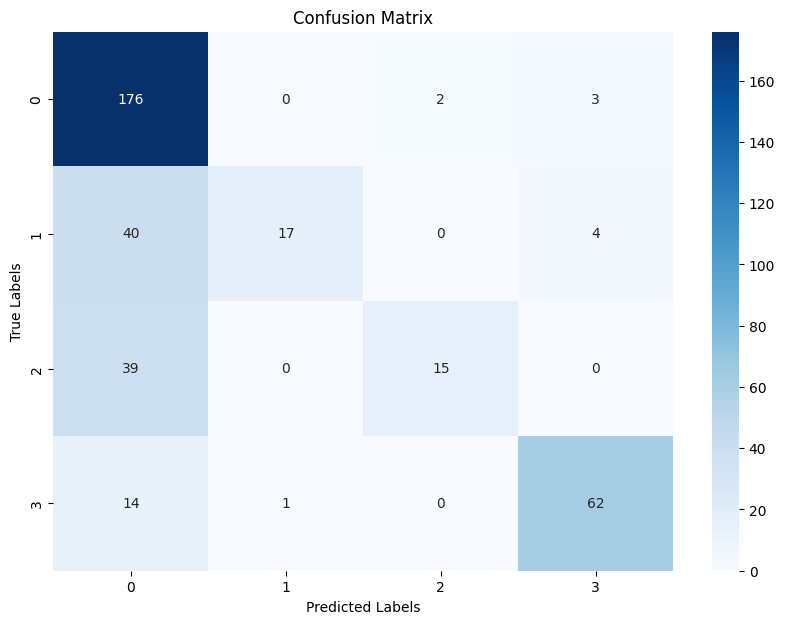

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

# csv_file = r"C:\Users\Paolo\Documents\carol_emo_rec\MLLM\idk\emotion_results_all.csv"  # Replace with your CSV file path
data = pd.read_csv(csv_file)

# Extract "Label" and "Mapped Value" columns
true_labels = data["Label"].astype(int)
predicted_labels = data["Mapped Value"].astype(int)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'macro' for unweighted F1
uar = recall_score(true_labels, predicted_labels, average='macro')  # Macro-average Recall is UAR

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"UAR (Unweighted Average Recall): {uar:.4f}")
print(f"F1-Score: {f1:.4f}")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
